In [1]:
'''
Licensed Materials - Property of IBM
IBM Maximo APM - Predictive Maintenance Insights On-Premises
IBM Maximo APM - Predictive Maintenance Insights SaaS 
© Copyright IBM Corp. 2019 All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.
'''

'\nLicensed Materials - Property of IBM\nIBM Maximo APM - Predictive Maintenance Insights On-Premises\nIBM Maximo APM - Predictive Maintenance Insights SaaS \n© Copyright IBM Corp. 2019 All Rights Reserved.\nUS Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.\n'

# Maximo APM PMI - Failure Probability Model Template

1. [Introduction](#introduction)
2. [Install Maximo APM PMI SDK](#install-maximo-apm-pmi-sdk)
3. [Setup the Model Training Pipeline](#setup-model-training-pipline)
4. [Train the Model Instance](#train-model-instance)
5. [Register the Trained Model Instance](#register-trained-model-instance)
6. [Model Template Internals](#model-template-internals)

<a id='introduction'></a>
## Introduction

In this notebook, we will be predicting imminent failures for assets using IoT sensor data and past failure history data. Our goal is to build models that can characterize the probability that a given asset with fail within a given future prediction window. We will perform the prediction for 15, 30 and 60 days. The temporal granularity of the prediction window can be tuned as required.

This data are derived from an actual oil-platform but the field names have been anonymized. We'll be building failure prediction models for a particular asset type _**Pumps**_. In the following image, a time series of sensor data is generated where we consider the recent sensor data history for a predefined interval and extract features from it. We also look ahead into the future for a fixed window to generate the target labels. The idea is to build a machine learning pipeline which characterizes the "pre-failure signal" from the extracted features.

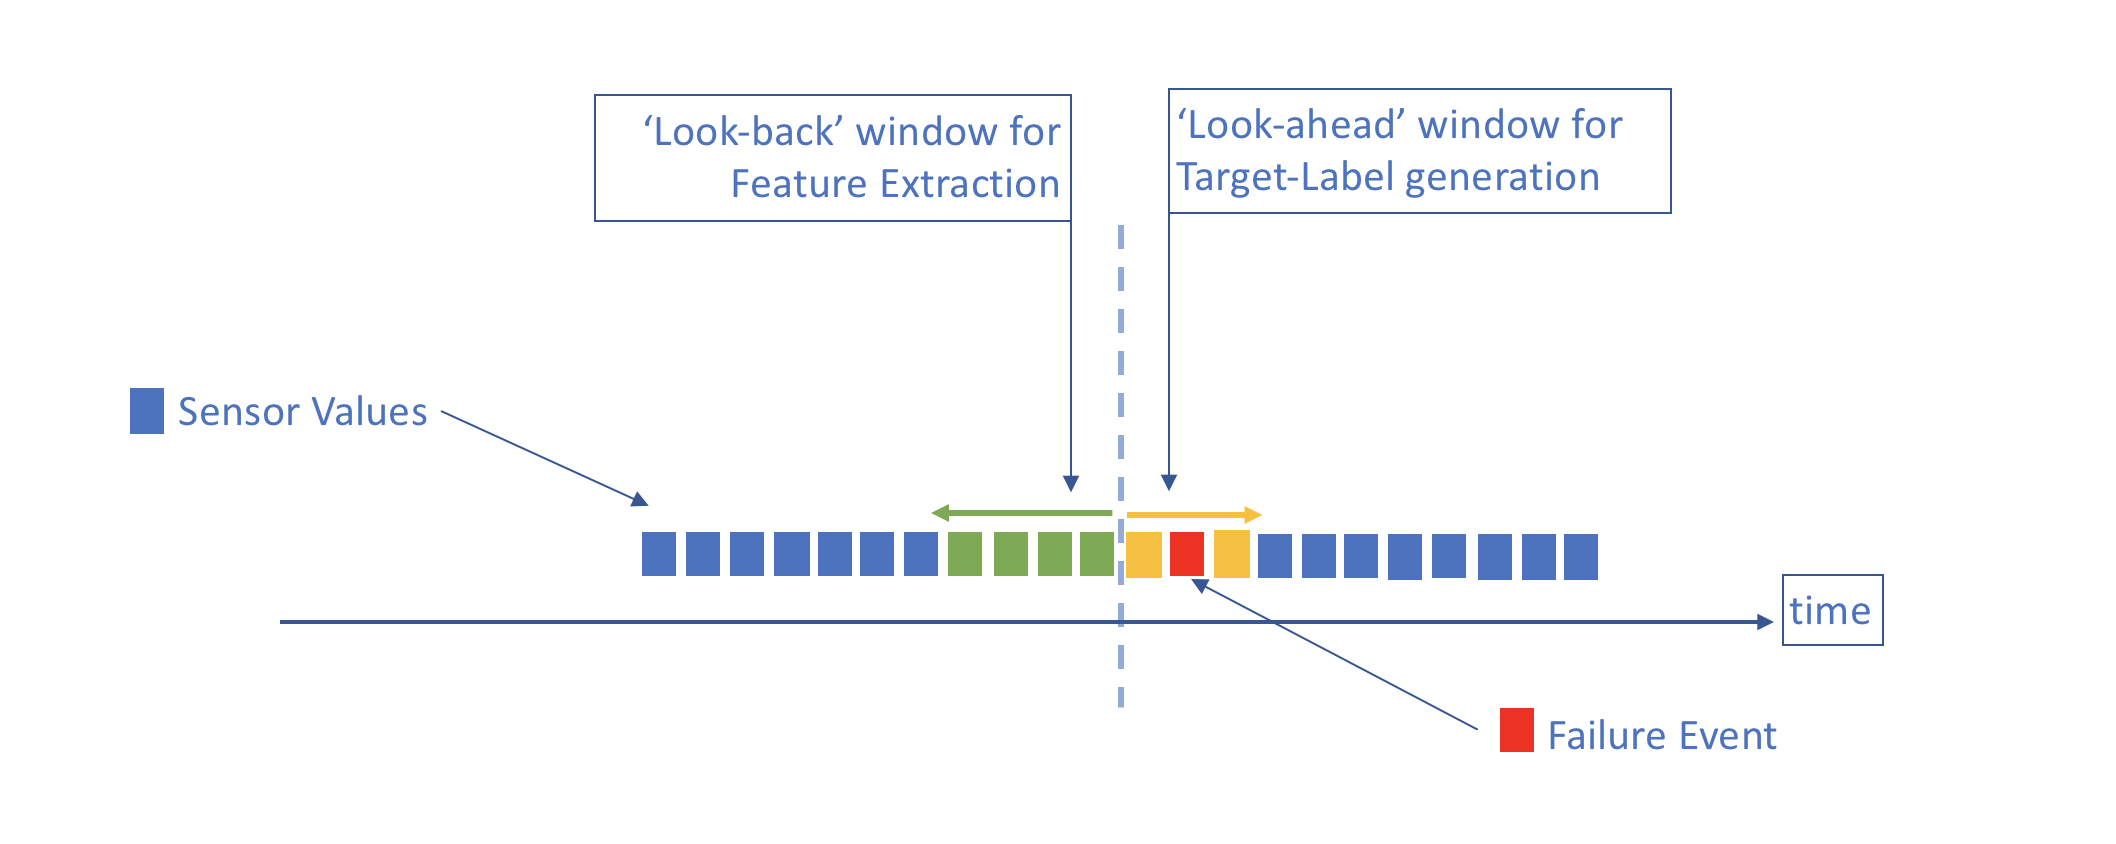

<a id="install-maximo-apm-pmi-sdk"></a>
## Install Maximo APM PMI SDK

To install the SDK, you need your Maximo APM PMI instance ID, API base URL, and your API key. The Maximo APM PMI instance ID and API base URL can be found in the user welcome letter. For API key, request to your Maximo admin to create an user account first to generate one for you. Create one environment variable for each here.

In [2]:
%%capture
%env APM_ID=4ac3917e
%env APM_API_BASEURL=https://prod.pmi.apm.maximo.ibm.com
%env APM_API_KEY=dp7opk78635sbf809f07o4t53lum3c9eoaovpk9f

Then, install PMI SDK with `pip`. Note that we have to upgrade `pip` first.

In [3]:
!pip install -U pip~=18.1
!pip install pyspark
!pip install -U https://prod.pmi.apm.maximo.ibm.com/ibm/pmi/service/rest/ds/4ac3917e/dp7opk78635sbf809f07o4t53lum3c9eoaovpk9f/lib/download?filename=pmlib-1.0.0.tar.gz

Requirement already up-to-date: pip~=18.1 in /opt/conda/envs/Python36/lib/python3.6/site-packages (18.1)
    100% |████████████████████████████████| 798kB 55.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for pmlib ... done
  Stored in directory: /home/dsxuser/.tmp/pip-ephem-wheel-cache-5g027m7c/wheels/27/e3/4f/8f4f27f0744ea9362917922e6990c31fc7ed89833aa12f6e3a
Successfully built pmlib
  Found existing installation: pmlib 1.0.0
    Uninstalling pmlib-1.0.0:
      Successfully uninstalled pmlib-1.0.0


<a id="setup-model-training-pipline"></a>
## Setup the Model Training Pipeline

Before you can start working on the model training pipeline, you have to setup an asset group and asset-sensor relationshp properly in Maximo. See IBM Maximo APM - Predictive MaintenanceInsights SaaS User Guide for details.

Required model pipeline configuration:

* Asset group ID: The unit of model processing is an asset group. Asset groups are managed on Maximo APM UI. You need to get the ID of the asset group to be analyzed by this model.
* Asset failure history as the label: This model requires asset failure history (Asset Workorder attribute **```faildate```** in Maximo) to extract the label for training.
* Sensor data as features: This model also accepts one or more features from either asset data or IOT data. **Note that these features must be of numeric type.** Features are specifed simply by attribute names prefixed by type (with separator colon). For asset attribute, the prefix is an empty string. For IOT data attribute, the prefix is the device type registered on Watson IOT Platform.
* Prediction output names: This model generates two outputs, the predicted failure failure probability and the root cause analysis decision tree path. Give them names (containing only alphanumeric, dash, and underline). **Note that the order of the two names matters, the first must be the predicted failure probability.**
* Aggregation methods: The features to this model are generated from the sensor data by finding rolling averages over a fixed window size for the entire dataset. Since we want to use the previous N days sensor data to predict whether a failure event is going to take place in the future, we use a "look-back" window of N days. We can use different aggregation methods like mean, maximum, minimum, median, standard deviation, sum, count for computing the rolling values. If it is not given, the default uses **```['mean', 'max', 'min', 'median', 'std', 'sum', 'count']```**.
* Prediction window size: This model can compute the probability of asset failure within a given future prediction window. The prediction window is specified in [Pandas offset alias](http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). Examples: "```15d```" for 15 days, "```30d```" for 30 days.

Now you can setup a training pipeine based on this model template, with your own data, to train a model instance.

In [4]:
from pmlib.failure_prediction import FailurePredictionAssetGroupPipeline

group = FailurePredictionAssetGroupPipeline(
            asset_group_id='1016', 
            model_pipeline={
                "features": ["IIOT:rh", "IIOT:temp", "IIOT:pressure", "IIOT:flow", "IIOT:vibration", "IIOT:energy"],
                "features_for_training": [":faildate"],
                "predictions": ["failure_probability_15d", "rca_path_15d"],
                "aggregation_methods": ["mean", "max", "min", "median", "std", "sum", "count"],
                "prediction_window_size": "15d",
            })

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GraphLasso is deprecated; The 'GraphLasso' was renamed to 'GraphicalLasso' in version 0.20 and will be removed in 0.22.
  warnings.warn(msg, category=DeprecationWarning)


2020-03-30T09:21:18.398 pmlib.api.init_environ INFO APM_ID=4ac3917e, APM_API_BASEURL=https://prod.pmi.apm.maximo.ibm.com, APM_API_KEY=********
2020-03-30T09:21:18.400 pmlib.util.api_request INFO method=get, url=https://prod.pmi.apm.maximo.ibm.com/ibm/pmi/service/rest/ds/tenant?instanceId=4ac3917e, headers={'apmapitoken': '********'}, timeout=30, ssl_verify=True, json=None, session=None, kwargs={}
2020-03-30T09:21:21.408 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://prod.pmi.apm.maximo.ibm.com/ibm/pmi/service/rest/ds/tenant?instanceId=4ac3917e
2020-03-30T09:21:21.412 pmlib.api.init_environ DEBUG resp={
    "as_apikey": "********",
    "as_apitoken": "********",
    "as_id": null,
    "as_url": "https://api-us.connectedproducts.internetofthings.ibmcloud.com",
    "info": {
        "API_BASEURL": "https://api-us.connectedproducts.internetofthings.ibmcloud.com",
        "API_KEY": "********",
        "API_TOKEN": "********",
        "COS_BUCKET_KPI": "analytics-

The example above configured a pipeline for this model, accepting **```sensor_1```, ```sensor_2```**, and **```sensor_3```** of Watson IOT Platform device type **```SampleFailureSensor```**. It also uses asset attribute **```faildate```** to extract the labels for training. The predicted output of the trained model instance is called **```failure_probability_15d```** (for predicted probability) and **```rca_path_15d```** (for root cause analysis decision tree path). The pipeline is also configured with a preprocessing stage generating aggregation metrics: mean, max, min, median, std, sum, and count, as extra features to the model. Finally, this pipeline is configured to predict for the future 15 days.

By default, this model also generated daily and group daily aggregated prediction result taking output names in the form of **```daily_<failure_probability_output_name>```** and **```group_daily_<failure_probability_output_name>```**.

<a id="train-model-instance"></a>
## Train the Model Instance

Now you can train the model instance.

In [5]:
df = group.execute()

2020-03-30T09:21:28.243 analytics_service.pmlib.cache_loader.AssetCacheRefresher.execute INFO start_ts=None, end_ts=None, entities=None
2020-03-30T09:21:33.866 pmlib.util.api_request INFO method=get, url=https://api-us.connectedproducts.internetofthings.ibmcloud.com/api/meta/v1/CTP-PMI-Democore-31/entityType/ASSET_CACHE, headers={'Content-Type': 'application/json', 'X-api-key': '********', 'X-api-token': '********', 'Cache-Control': 'no-cache'}, timeout=30, ssl_verify=True, json=None, session=None, kwargs={}
2020-03-30T09:21:34.574 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://api-us.connectedproducts.internetofthings.ibmcloud.com/api/meta/v1/CTP-PMI-Democore-31/entityType/ASSET_CACHE
2020-03-30T09:21:34.590 iotfunctions.metadata.__init__ DEBUG Initializing new entity type using iotfunctions 2.0.3
2020-03-30T09:21:34.592 iotfunctions.util.__init__ DEBUG Starting trace
2020-03-30T09:21:34.593 iotfunctions.util.__init__ DEBUG Trace name: auto_trace_ASSET_CACHE

Once this method completes successfully, you'll have a trained model instance reday (for next step, see below) and also with the prediction results returned as a dataframe for verification.

<a id="register-trained-model-instance"></a>
## Register the Trained Model Instance


If the trained model instance looks good, you can register it to Maximo APM PMI:

group.register()

In [6]:
group.register()

2020-03-30T09:27:28.397 analytics_service.pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.register DEBUG target_pipeilne_class=pmlib.failure_prediction.FailurePredictionAssetGroupPipeline, url=None
2020-03-30T09:27:28.398 analytics_service.pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.register DEBUG catalog_config={'name': 'FailurePredictionAssetGroupPipeline', 'description': 'FailurePredictionAssetGroupPipeline', 'moduleAndTargetName': 'pmlib.failure_prediction.FailurePredictionAssetGroupPipeline', 'url': 'https://prod.pmi.apm.maximo.ibm.com/ibm/pmi/service/rest/ds/4ac3917e/dp7opk78635sbf809f07o4t53lum3c9eoaovpk9f/lib/download?filename=pmlib-1.0.0.tar.gz', 'category': 'TRANSFORMER', 'tags': [], 'output': [{'name': 'names', 'description': 'Provide a list of output names to be generated from the pipeline.', 'dataType': 'ARRAY', 'jsonSchema': {'minItems': 1, '$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'array', 'items': {'type': 'string'}}, 't

'8AB50287-699C-4E8E-8570-FFEBA41AA7F8'

Once registration succeeds, you can see this newly trained model instance available for the asset group on IBM Maximo APM UI.

<a id="model-template-internals"></a>
## Model Template Internals

#### Use Case Description

This model deals with computing failure probabilities for various entities such as machine, equipment, process etc. The failure probability is computed using variables and historical failure data. Variables include things like sensor data, events, process related values, and things like fault codes etc. The objective here is to build models that can compute the probability for a set of assets to fail within a given future prediction window. The definiton of "failure" can be defined according to the business requirements and the use case. The temporal granularity of the prediction window can be tuned as required.

This model can be used to predict failure patterns involving a machine, or device, equipment, tool or a process where timestamped variables can be gathered along with failure data. Since this uses supervised learning methods, historical failure records are mandatory for this model to work. Besides, this model can also give a Root Cause Analysis to find the causes of the asset failure.

Using this model one can answer the questions of the following pattern:

   **What are the top 'k' assets that have the propernsity to fail in the next 'n' days?**

   **Identify the top 'k' assets in the descending order of failure probability, that are likely to fail in the next 'n' days**

   **The root cause of the asset failure**

This model, once deployed, can be invoked periodically in a batch mode for a large group of assets or processes to generate failure probabilities and root causes on an ongoing basis. 

The notebook shows the model building, training, and register on PMI.

##### Input Data (from IOT plaform and Maximo, PMI SDK will do this part)

+ Time-series sensor data for the assets, or other process variable as a discrete time variable data. 
+ Time-series failure data for the assets, or the process

##### Output

The output will be a list of assets and their associated failure probabilities within a given timewindow. **`failure_probability_15d`** means the asset's failure probability in next 15 days. And **`rca_path_15d`** means the asset's root cause path in next 15 days.

| id | event_timestamp | failure_probability_15d | rca_path_15d
| --- | --- | --- | --- |
| SAMPLE_ASSET011 | 2017-04-26 | 0.2 | [0, 1, 5, 6]
| SAMPLE_ASSET011 | 2017-05-21 | 0.3 | [0, 1, 5, 6]
| SAMPLE_ASSET012 | 2017-04-28 | 0.7 | [0, 2, 4, 9, 11]
| SAMPLE_ASSET013 | 2017-05-10 | 0.9 | [0, 2, 3, 6]

##### Customization Points

+ Time window for computation of the failure probability (**`prediction_window_size`** in cell **`Setup the Model Training Pipeline`**)
+ Feature engineering. Depending on the data, it may be necessary to carry out specific transformation and feature engineering steps to align with the input data schema (**`FailurePredictionEstimatorFeatureExtraction`** Class in below model template code)
+ Failure Prediction algorithm based on Srom (**`FailurePredictionEstimator`** Class in below model template code)
+ Root Cause Analysis algorithm based on Srom (**`FailurePredictionRcaEstimator`** Class in below model template code)
+ Model pipeline stages control (**`FailurePredictionAssetGroupPipeline`** Class in below model template code)

##### Model Workflow and Description

The sensor data is gathered for a predefined interval and features are extracted from it. Depending on the time window (look ahead window) for the computation of failure probability, target labels are generated apporpriately. The idea is to build a machine learning pipeline which characterizes the "pre-failure signal" from the extracted features.

The following steps are involved in predicting the failure:

###### Feature Engineering

This step involves performing feature engineering to extract potentially useful modeling features. This model extracts features from the raw dataset to be used, and as a data scientist, you can either use it as is, or create additional features if your data is complex and / or potentially different. When you are dealing with process related variables, or unstructured data, or non-sensor data, those may be the situations when you would like to determine the kind of features, and how to create them. In the current notebook with the dataset involving sensor measurements, features are created from the sensor table by specifying the aggregation methods and rolling window size. The target labels are generated for the future windows which act as ground truth while training the model and valiadating it.

###### Model building:

Data-driven models are constructued by using machine learning algorithms defined into SROM pipelines. Model accuracy can be assessed by prediction functions.



In [7]:
class FailurePredictionEstimator(SromEstimator):
    def configure_pipeline(self, srom_pipeline):
        srom_pipeline.add_input_meta_data(label_column=self.features_for_training[0])
        srom_pipeline.set_scoring('accuracy')
        return srom_pipeline

    def get_stages(self):
        return [
            [
                NoOp(), 
                StandardScaler(), 
                RobustScaler(), 
                MinMaxScaler()
            ],
            [
                PCA(), 
                SelectKBest(k=2)
            ],
            [ 
                DecisionTreeClassifier(),
                AdaBoostClassifier(),
                RandomForestClassifier()
            ]
        ]

    def get_param_grid(self):
        from srom.pipeline import SROMParamGrid
        return SROMParamGrid(gridtype='empty')

    def get_prediction_result_value_index(self):
        return (1, 1)


class FailurePredictionEstimatorFeatureExtraction(BaseTransformer):
    def __init__(self, features, features_for_training, entity_type, prediction_window_size):
        super().__init__()
        self.logger = get_logger(self)
        self.features = features
        self.features_for_training = features_for_training
        self.entity_type = entity_type
        self.prediction_window_size = prediction_window_size

    def execute(self, df):
        self.logger.debug('df_input: %s' % log_df_info(df, head=5))
        self.logger.debug('df_input_labeled: %s' % log_df_info(df[df[self.features_for_training[0]] == 1], head=5))

        df_index_id_name, df_index_timestamp_name = self.entity_type._df_index_entity_id, self.entity_type._timestamp
        srom_id_name, srom_timestamp_name = 'asset_id', 'datetime'

        df_original = df

        df = df.reset_index()
        df[srom_timestamp_name] = df[df_index_timestamp_name].dt.floor('d')

        self.logger.debug('df_input_after_to_day: %s' % log_df_info(df, head=5))

        df_train = df.drop(columns=self.features_for_training).dropna(subset=self.features)
        self.logger.debug('df_train: %s' % log_df_info(df_train, head=5))

        df_failure = df[[df_index_id_name, df_index_timestamp_name, srom_timestamp_name] + self.features_for_training].dropna(subset=self.features_for_training)
        self.logger.debug('df_failure: %s' % log_df_info(df_failure, head=5))

        from srom.failure_prediction.preprocessing import generate_key_col
        failure_keys = generate_key_col(df=df_train,
                                        date_clm=srom_timestamp_name,
                                        asset_id_clm=df_index_id_name,
                                        interval={'days': 1})
        self.logger.debug('failure_keys: %s' % log_df_info(failure_keys, head=5))

        from srom.failure_prediction.preprocessing import generate_failure_targets
        failure_type = 1 
        # Generating the labels and saving them
        failure_target_table = generate_failure_targets(
            failure_table=df_failure, 
            failure_keys=failure_keys, 
            failure_detection_window_size=self.prediction_window_size, 
            failure_asset_id=df_index_id_name, 
            failure_date=srom_timestamp_name, 
            failure_id=self.features_for_training[0])
        self.logger.debug('failure_target_table: %s' % log_df_info(failure_target_table, head=5))

        failure_target_table = failure_target_table.rename(columns={
            srom_id_name: df_index_id_name, 
        }) 

        df = pd.merge(failure_target_table, df_train, on=[df_index_id_name, srom_timestamp_name], how='outer')
        df = df.rename(columns={'target_label': self.features_for_training[0]})
        df = df.set_index(keys=[df_index_id_name, df_index_timestamp_name])

        self.logger.debug('df_final: %s' % log_df_info(df, head=5))
        df = df.dropna()
        self.logger.debug('df_final: %s' % log_df_info(df, head=5))

        return df


class FailurePredictionRcaEstimator(SromEstimator):
    def configure_pipeline(self, srom_pipeline):
        srom_pipeline.add_input_meta_data(label_column=self.features_for_training[0])
        srom_pipeline.set_scoring('accuracy')
        return srom_pipeline

    def get_stages(self):
        return [
            [
                # ('All Features', NoOp()), 
                ('SelectKBest - f_classif 20', SelectKBest(k=20)),
                ('SelectKBest - f_classif 10', SelectKBest(k=10)),
                ('SelectKBest - f_classif 5', SelectKBest(k=5))
            ],
            [
                ('Decision Tree Classifier', DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01))
            ]
        ]

    def get_param_grid(self):
        from srom.pipeline import SROMParamGrid
        return SROMParamGrid(gridtype='empty')

    def process_prediction_result(self, df, prediction_result, model):
        self.logger.debug('prediction_result_length=%d, prediction_result=%s' % (len(prediction_result), str(prediction_result[:10])))

        model = model.get_best_estimator()

        dff = self.get_df_for_prediction(df)
        extracted_features_columns = dff.columns
        self.logger.debug('extracted_features_columns=%s' % str(extracted_features_columns))
        features_used = []
        for step in model.steps:
            if isinstance(step[1], SelectKBest):
                mask = step[1].get_support()
                self.logger.debug('step_name=%s, mask=%s' % (str(step[0]), str(mask)))
                for i, col_name in enumerate(extracted_features_columns):
                    if mask[i]:
                        features_used.append(col_name)

            step_name = step[0]
            if step_name != 'Decision Tree Classifier':
                dff = model.named_steps[step_name].transform(dff)
                self.logger.debug('step_name=%s, dff=%s' % (step_name, log_df_info(dff, head=5)))
            else:
                break

        self.logger.debug('features_used=%s' % str(features_used))
        self.logger.debug('final dff=%s' % (log_df_info(dff, head=5)))

        decision_path_output = self._simple_decision_path(model.named_steps['Decision Tree Classifier'], dff)
        self.logger.debug('decision_path_output_length=%s, decision_path_output=%s' % (len(decision_path_output), str(decision_path_output[:10])))

        df[self.predictions[0]] = decision_path_output

        return df

    def get_model_extra(self, new_model, model_path):
        extras = []

        decision_tree = new_model.get_best_estimator().named_steps['Decision Tree Classifier']

        feat_importance1 = decision_tree.feature_importances_
        self.logger.debug('feat_importance1=%s' % str(feat_importance1))

        features_used = []
        extracted_features_columns = self.features
        self.logger.debug('extracted_features_columns=%s' % str(extracted_features_columns))
        for step in new_model.get_best_estimator().steps:
            if isinstance(step[1], SelectKBest):
                mask = step[1].get_support()
                self.logger.debug('step_name=%s, mask=%s' % (str(step[0]), str(mask)))
                for i, col_name in enumerate(extracted_features_columns):
                    if mask[i]:
                        features_used.append(col_name)
        self.logger.debug('features_used=%s' % str(features_used))

        feat_importance = []
        node = ['X'+str(i) for i in range(len(features_used))]
        for i, feat in enumerate(features_used):
            feat_ = feat.split('__')
            if len(feat_) > 2:
                feat_ = feat_[0:2]
            if feat_importance1[i] != 0:
                # feat_importance.append([node[i], feat, round(feat_importance1[i], 5)])
                feat_importance.append([feat, feat, round(feat_importance1[i], 5)])
        self.logger.debug('feat_importance=%s' % str(feat_importance))

        feat_importance.sort(key=lambda x: x[2], reverse=True)
        self.logger.debug('sorted_feat_importance=%s' % str(feat_importance))

        model_features_path = model_path + '_features'
        extras.append((model_features_path, json.dumps(feat_importance), False, False))

        dot_data = tree.export_graphviz(
            decision_tree, 
            out_file=None,
            filled=True, 
            rounded=True, 
            impurity=False, 
            special_characters=True,
            feature_names=features_used) 
        model_tree_path = model_path + '_tree'
        extras.append((model_tree_path, dot_data, False, False))

        self.logger.debug('extras=%s' % str(extras))

        return extras

    def _simple_decision_path(self, estimator, df):
        path = estimator.decision_path(df)   # scipy sparse matrix
        path = path.toarray()  # numpy matrix
        decision_path_list = []
        for i in range(path.shape[0]):
            path1 = [j for j in range(path.shape[1]) if path[i,j] == 1]
            decision_path_list.append(str(path1))
        return decision_path_list


class FailurePredictionAssetGroupPipeline(AssetGroupPipeline):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.model_template_name = 'Failure Probability'

        # exclude labels from normal fillna/dropna logic

        if self.fillna_exclude is None:
            self.fillna_exclude = []
        if self.pipeline_config.features_for_training is not None:
            self.fillna_exclude.extend(self.pipeline_config.features_for_training)
            self.fillna_exclude = list(set(self.fillna_exclude))

        if self.dropna_exclude is None:
            self.dropna_exclude = []
        if self.pipeline_config.features_for_training is not None:
            self.dropna_exclude.extend(self.pipeline_config.features_for_training)
            self.dropna_exclude = list(set(self.dropna_exclude))

        # default aggregation post-processing
        prediction = self.pipeline_config.predictions[0]
        default_post_processing = [
            {
                "functionName": "Maximum",
                "enabled": True,
                "granularity": "Daily",
                "output": {
                    "name": "daily_%s" % prediction
                },
                "input": {
                    "source": prediction
                }
            },
            {
                "functionName": "Mean",
                "enabled": True,
                "granularity": "GroupDaily",
                "output": {
                    "name": "group_daily_%s" % prediction
                },
                "input": {
                    "source": "daily_%s" % prediction
                }
            }
        ]
        if self.post_processing is None:
            self.post_processing = default_post_processing
        else:
            for agg in default_post_processing:
                if agg not in self.post_processing:
                    self.post_processing.append(agg)

    def prepare_execute(self, pipeline, model_config):
        if 'rolling_window_size' not in model_config or model_config['rolling_window_size'] is None:
            model_config['rolling_window_size'] = model_config['prediction_window_size']

        pipeline.add_stage(SimpleSummaryStatistics(data_items=model_config['features'].copy(), aggregation_methods=model_config['aggregation_methods'], rolling_window_size=model_config['rolling_window_size']))

        # don't touch the original one
        model_config = model_config.copy()
        model_config['features'] = model_config['features'].copy()

        # add the generated satatistics into model_config.features
        model_config['features'].extend([(feature + '__' + aggr + '__' + str(model_config['rolling_window_size'])) for aggr in model_config['aggregation_methods'] for feature in model_config['features']])

        predictions = model_config['predictions'].copy()

        model_config['predictions'] = [predictions[0]]
        estimator = FailurePredictionEstimator(**model_config)
        model_config['predictions'] = predictions
        # Add training preprocessing stages
        estimator.add_training_preprocessor(TransformNotNaToEvent(model_config['features_for_training'][0]))
        estimator.add_training_preprocessor(FailurePredictionEstimatorFeatureExtraction(features=model_config['features'], features_for_training=model_config['features_for_training'], entity_type=self._entity_type, prediction_window_size=model_config['prediction_window_size']))
        pipeline.add_stage(estimator)

        model_config['predictions'] = [predictions[1]]
        estimator2 = FailurePredictionRcaEstimator(**model_config)
        model_config['predictions'] = predictions
        # Add training preprocessing stages
        estimator2.add_training_preprocessor(TransformNotNaToEvent(model_config['features_for_training'][0]))
        estimator2.add_training_preprocessor(FailurePredictionEstimatorFeatureExtraction(features=model_config['features'], features_for_training=model_config['features_for_training'], entity_type=self._entity_type, prediction_window_size=model_config['prediction_window_size']))
        pipeline.add_stage(estimator2)

    def get_prediction_backtrack(self):
        reset = DateOffset(**{"hour": 0, "minute": 0, "second": 0, "microsecond": 0})
        offset = to_offset(self.pipeline_config['prediction_window_size'])
        return [[reset, offset], [reset]]

    @staticmethod
    def generate_sample_data(sensor_type_name, **kwargs):
        return generate_failure_probability_data(sensor_type_name=sensor_type_name, **kwargs)

NameError: name 'SromEstimator' is not defined

## How to override base class
If you want to customize some functions in the model template, you can just override or add the function. For example **`FailurePredictionRcaEstimator(SromEstimator)`**. It is based on the base class **`SromEstimator`** you can:
+ override the existing method in **`SromEstimator`** (like **`configure_pipeline`** method to customize your specific training pipeline)
+ add new function like **`get_stages`** to configure Decision Tree Classifiers for the algorithm.

    def configure_pipeline(self, srom_pipeline):
        srom_pipeline.add_input_meta_data(label_column=self.features_for_training[0])
        srom_pipeline.set_scoring('accuracy')
        return srom_pipeline

    def get_stages(self):
        return [
            [
                ('SelectKBest - f_classif 20', SelectKBest(k=20)),
                ('SelectKBest - f_classif 10', SelectKBest(k=10)),
                ('SelectKBest - f_classif 5', SelectKBest(k=5))
            ],
            [
                ('Decision Tree Classifier', DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01))
            ]
        ]

#### Base class `SromEstimator`

In [ ]:
class SromEstimator(BaseEstimator):
    def __init__(self, features, targets, predictions, srom_training_options=None, **kwargs):
        super().__init__(features=features, targets=targets, predictions=predictions, **kwargs)
        self._set_srom_training_optins(srom_training_options)

    def _set_srom_training_optins(self, srom_training_options):
        self.srom_training_options = srom_training_options
        if self.srom_training_options is None:
            self.srom_training_options = {}
        if 'verbosity' not in self.srom_training_options:
            self.srom_training_options['verbosity'] = 'low'
        if 'exectype' not in self.srom_training_options:
            self.srom_training_options['exectype'] = 'single_node_complete_search'
        if 'num_option_per_pipeline' not in self.srom_training_options:
            self.srom_training_options['num_option_per_pipeline'] = 1
        if 'max_eval_time_minute' not in self.srom_training_options:
            self.srom_training_options['max_eval_time_minute'] = 1

    def train_model(self, df):
        srom_pipeline = self.create_pipeline()
        srom_pipeline = self.configure_pipeline(srom_pipeline)
        srom_pipeline.set_stages(self.get_stages())

        df_train = df
        if isinstance(srom_pipeline, AnomalyPipeline):
            label = self.features_for_training[0]
            df_train = df[pd.isna(df[label])].drop(labels=label, axis=1, errors='ignore').reset_index(drop=True)
            self.logger.debug('trainX: %s' % log_df_info(df_train, head=5))

            validX = df[pd.notna(df[label])].drop(labels=label, axis=1, errors='ignore').reset_index(drop=True)
            validy = df[pd.notna(df[label])][label].reset_index(drop=True)
            self.logger.debug('validX: %s' % log_df_info(validX, head=5))
            self.logger.debug('validy: %s' % log_df_info(validy, head=5))

            srom_pipeline.execute(
                trainX=df_train, 
                validX=validX, 
                validy=validy, 
                param_grid=self.get_param_grid(), 
                **self.srom_training_options)
        else:
            srom_pipeline.execute(
                df_train, 
                param_grid=self.get_param_grid(), 
                **self.srom_training_options)

        srom_pipeline.fit(df_train)

        return srom_pipeline

    def create_pipeline(self):
        return SROMPipeline()

    def configure_pipeline(self, srom_pipeline):
        return srom_pipeline